In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import Lasso
import math

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Machine Learning and Prediction

## Can we infer from transaction metadata, the Senator who placed such transaction?

Some of the existing columns are not needed for prediction (for instance, link to original PDF). Others, such as asset_type is redundant, since only stocks are considered. 

I also intentionally removed the "State" variable as a potential predictor. This was done because there are only 2 Senators from each state, and I wanted to challenge the ML models to predict without such information.

We can however, generate (potentially) helpful predictors. For instance, Senators may differ in their propensity to file their disclosure statements. The duration between filing date and transaction could be useful in infering the identity of the investor.

In [30]:
senate_stocks_raw_df = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Final Project/senate_stocks_raw_df.pkl", "rb"))

# Let us first extract year, month and day of investment
senate_stocks_raw_df["year_invested"] = pd.to_datetime(senate_stocks_raw_df['transaction_date']).dt.strftime('%Y')
senate_stocks_raw_df["month_invested"] = pd.to_datetime(senate_stocks_raw_df['transaction_date']).dt.strftime('%m')
senate_stocks_raw_df["day_invested"] = pd.to_datetime(senate_stocks_raw_df['transaction_date']).dt.strftime('%d')

# How long do Senators wait to disclose?
senate_stocks_raw_df["time_to_disclosure"] = (pd.to_datetime(senate_stocks_raw_df['disclosure_date'])-pd.to_datetime(senate_stocks_raw_df['transaction_date'])).astype('str').str[:-4].astype('int')

# Remove unnecessary columns
senate_stocks_raw_df = senate_stocks_raw_df.drop(["transaction_date", "comment", "ptr_link", "disclosure_date", "asset_description", "asset_type", "state"], axis=1)

# Remove senators who rarely trade
freq_trading = pd.DataFrame(senate_stocks_raw_df["senator"].value_counts()).reset_index()
freq_trading.columns = ["senator", "freq"]
freq_traders = freq_trading[freq_trading["freq"] > 20].senator.unique()
senate_stocks_raw_df = senate_stocks_raw_df[senate_stocks_raw_df["senator"].isin(freq_traders)]


In [31]:
X = senate_stocks_raw_df.loc[:, senate_stocks_raw_df.columns != "senator"]
y = senate_stocks_raw_df["senator"]

# We leave 50% of data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=100)

**KNN Classifier**

In [32]:
# KNN Classifier 

# Pre-processor: this preprocessor will process ALL predictors
KNN_preprocessor = ColumnTransformer(transformers=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"), ["owner", "industry", "ticker", "type", "amount", "party","sector", "year_invested", "month_invested", "day_invested"]),
        ("scaler", StandardScaler(), ["time_to_disclosure"])],
        remainder="drop")

# Make pipeline
KNN_pipeline = make_pipeline(KNN_preprocessor,
                             KNeighborsClassifier(n_neighbors=3, metric="euclidean"))

# Assess performance
est_testing_score = cross_val_score(KNN_pipeline, X_train, y_train, scoring="f1_macro", cv=10)
print("Predicted Testing Score:", est_testing_score.mean())

KNN_pipeline.fit(X_train, y_train)
predicted_y = KNN_pipeline.predict(X_test)
testing_score = f1_score(y_test, predicted_y, average='macro')
print("Actual Testing Score:", testing_score)

Predicted Testing Score: 0.7093793406473129
Actual Testing Score: 0.750741723412402


We attain an average F1 Score of ~0.70 (in both the training and actual testing dataset), which is pretty close to 1!

A simple KNN classifier works pretty well. 

Let us attempt to visualize how the value of K affects the performance of the KNN model.

In [43]:
# Find estimated test and actual test score for different k

ks =  [2, 3, 4, 5, 10, 15]
est_test_f1, actual_test_f1 = [], []

for k in ks:
  # update n_neighbors for each version of model with k
  KNN_pipeline = make_pipeline(KNN_preprocessor, KNeighborsClassifier(n_neighbors=k, 
                                                                      metric="euclidean"))

  # find estimated test score
  est_test_score = cross_val_score(KNN_pipeline, 
                              X_train, 
                              y_train, 
                              scoring="f1_macro", cv=5).mean()

  # find actual test score
  KNN_pipeline.fit(X_train, y_train)
  predicted_y = KNN_pipeline.predict(X_test)
  testing_score = f1_score(y_test, predicted_y, average='macro')

  
  # store train_error and test_mse
  est_test_f1 += [est_test_score]
  actual_test_f1 += [testing_score]

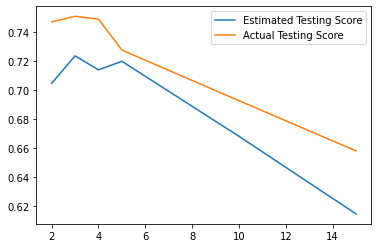

In [34]:
# Plot training error and estimated test errors
x = ks
y1 = est_test_f1
y2 = actual_test_f1

plt.plot(x, y1, label="Estimated Testing Score")
plt.plot(x, y2, label="Actual Testing Score")
plt.legend(loc="upper right")

Performance generally decreases as K increases.

Highest F1 scores attained at **K = 3**

**Let us now try a Random Forest Model**

In [35]:
# KNN Classifier 

# Pre-processor: this preprocessor will process ALL predictors
RF_preprocessor = ColumnTransformer(transformers=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"), ["owner", "industry", "ticker", "type", "amount", "party", "sector", "year_invested", "month_invested", "day_invested"]),
        ("scaler", StandardScaler(), ["time_to_disclosure"])],
        remainder="drop")

# Make pipeline
RF_pipeline = make_pipeline(KNN_preprocessor,
                            RandomForestClassifier())

# Assess performance
est_testing_score = cross_val_score(RF_pipeline, X_train, y_train, scoring="f1_macro", cv=10)
print("Predicted Testing Score:", est_testing_score.mean())

RF_pipeline.fit(X_train, y_train)
predicted_y = RF_pipeline.predict(X_test)
testing_score = f1_score(y_test, predicted_y, average='macro')
print("Actual Testing Score:", testing_score)

Predicted Testing Score: 0.7712903781535632
Actual Testing Score: 0.8234950321542049


An (untuned) Random Forest model seems to work even better than a simple KNN model, with higher F1 scores across both training and testing sets.

**Is it possible to improve the Random Forest further by tuning it?**



In [48]:

# Params to be tested for RandomForest; 
params_rf = {"randomforestclassifier__min_samples_split": [2,3,4],
             "randomforestclassifier__min_samples_leaf": [1,2,3],
             "randomforestclassifier__max_features": [None, "sqrt", "log2"],
             "randomforestclassifier__n_estimators": [10, 100, 500]}

# Use GridSearchCV to find the best combination of parameters for Gradient Boosting
grid_cv_rf = GridSearchCV(RF_pipeline,
                          param_grid=params_rf,
                          scoring="f1_macro", 
                          cv=5)

grid_cv_rf.fit(X_test, y_test)

print(grid_cv_rf.best_params_)
print(grid_cv_rf.best_score_)

{'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}
0.7840121761143222


No improvement in F1 score after tuning. Default params are sufficiently capable in predicting the identity of investors as is.

Before tuning: 0.821842404524501

After tuning: 0.7840121761143222

*Model -*

*{'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}*


### Is it possible to improve the F1 score via ensemble methods?



In [44]:
# Voting Ensemble Model
from sklearn.ensemble import VotingClassifier

voter = VotingClassifier([("KNN Model", KNN_pipeline),
                         ("Random Forest Model", RF_pipeline)])
voter_score = cross_val_score(voter, X_train, y_train, scoring="f1_macro", cv=5).mean()
print("voter score:", voter_score)

voter score: 0.7079206769284876


In [47]:
# Stacking Ensemble Model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingClassifier

stacker = StackingClassifier([("KNN Model", KNN_pipeline),
                             ("Random Forest Model", RF_pipeline)])


voter_score = cross_val_score(stacker, X_train, y_train, scoring="f1_macro", cv=5).mean()
print("voter score:", voter_score)


voter score: 0.6897060819961329


Neither the stacker nor voter ensemble model outperformed the stand-alone Random Forest model.

## Can we predict the average annualized return of Senators?

This question requires the cleaned dataset, in which returns were calculated for closed investments. 

Predictors include:
- party
- state
- avg. investment duration
- most favored sector
- most favored industry
- absolute_gain

In [ ]:
senators_cleaned = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Final Project/senators_data_vis_df.pkl", "rb"))

In [ ]:
# Get favorite sector and industry
freq_sector_df = pd.DataFrame(senators_cleaned.groupby(["senator"])["sector"].value_counts()).unstack().fillna(0).droplevel(0,axis=1)
freq_sector = pd.DataFrame(freq_sector_df.idxmax(axis=1)).reset_index()
freq_sector.columns = ["senator","sector"]

freq_industry_df = pd.DataFrame(senators_cleaned.groupby(["senator"])["industry"].value_counts()).unstack().fillna(0).droplevel(0,axis=1)
freq_industry = pd.DataFrame(freq_industry_df.idxmax(axis=1)).reset_index()
freq_industry.columns = ["senator","industry"]

# Get avg. investment duration
avg_invest_duration = pd.DataFrame(senators_cleaned.groupby(["senator"])["investment_duation"].mean()).unstack().fillna(0).reset_index()
avg_invest_duration.columns = ["des", "senator", "avg_invest_duration"]

# Get party affliation
freq_sector = freq_sector.merge(senators_cleaned[["senator","party"]], how="inner", on="senator").drop_duplicates()

# Get state
freq_sector = freq_sector.merge(senators_cleaned[["senator","state"]], how="inner", on="senator").drop_duplicates()

# Get avg. annualized return
senator_avg_return = pd.DataFrame(senators_cleaned.groupby("senator")["annualized_returns"].mean().reset_index())

# Get absolute gain
absolute_gain_by_senator_df = pd.DataFrame(senators_cleaned.groupby(["senator"])["absolute_gain"].sum()).sort_values("absolute_gain", ascending=False).reset_index()


In [ ]:
# Fill in new df
returns_df = freq_sector.copy()
returns_df = returns_df.merge(freq_industry[["senator", "industry"]], on="senator")
returns_df = returns_df.merge(avg_invest_duration[["senator", "avg_invest_duration"]], on="senator")
returns_df = returns_df.merge(absolute_gain_by_senator_df[["senator", "absolute_gain"]], on="senator")
returns_df = returns_df.merge(senator_avg_return[["senator", "annualized_returns"]], on="senator")
returns_df

,senator,sector,party,state,industry,avg_invest_duration,absolute_gain,annualized_returns
0,"Angus S. King, Jr.",Energy,Independent,ME,Oilfield Services/Equipment,994.000000,-5.304428e+03,-0.137478
1,Bill Cassidy,Consumer Services,Republican,LA,Computer Manufacturing,1220.500000,3.043481e+05,0.109341
2,Christopher A. Coons,Consumer Services,Democrat,DE,Consumer Electronics/Video Chains,62.000000,-6.385007e+02,-0.146784
3,Dan Sullivan,Technology,Republican,AK,Computer Software: Prepackaged Software,8.000000,8.178044e+02,9.399227
4,David Perdue,Energy,Republican,GA,Natural Gas Distribution,952.462366,2.296075e+06,0.055576
5,Jack Reed,Technology,Democrat,RI,Semiconductors,829.857143,1.077645e+05,0.102405
6,James M. Inhofe,Capital Goods,Republican,OK,Business Services,680.000000,6.057285e+05,0.112563
7,Jerry Moran,Finance,Republican,KS,Major Banks,423.400000,2.164454e+04,-0.095155
8,John Hoeven,Capital Goods,Republican,ND,Computer Manufacturing,559.000000,5.271045e+04,0.059081
9,Kelly Loeffler,Finance,Republican,GA,Property-Casualty Insurers,33.615385,5.353053e+05,19.497291


Because the final dataset is so small, let us use a simple **lasso regression model**.

In [ ]:
X = returns_df.loc[:, :"absolute_gain"]
y = returns_df["annualized_returns"]

In [ ]:
# Lasso model

# Pre-processor: this preprocessor will process ALL predictors

lasso_preprocessor = ColumnTransformer(transformers=[("onehot", OneHotEncoder(handle_unknown="ignore"), ["senator", "sector","party", "state", "industry"]),	
                                                      ("scaler", StandardScaler(), ["absolute_gain"])],
                                                      remainder="drop")

# Make pipeline
lasso_pipeline = make_pipeline(lasso_preprocessor,
                               Lasso())

# Assess performance
est_testing_score = cross_val_score(lasso_pipeline, X, y, scoring="neg_mean_squared_error", cv=4)
print(math.sqrt(-est_testing_score.mean()))


4.936340546374228


We have a RMSE of ~4.9 (490%), which is not so surprising considering that we have significant outliers (Dan Sullivan and Kelly Loeffler).

Let us try removing them from the regression model.

In [ ]:
returns_df_filtered = returns_df[~returns_df["senator"].isin(["Dan Sullivan", "Kelly Loeffler"])]
X = returns_df_filtered.loc[:, :"absolute_gain"]
y = returns_df_filtered["annualized_returns"]

# Assess performance
est_testing_score = cross_val_score(lasso_pipeline, X, y, scoring="neg_mean_squared_error", cv=4)
print(math.sqrt(-est_testing_score.mean()))

0.27023362745135626


Now, we have a more "reasonable" RMSE of ~0.33 (33%).

This RMSE is still too large to be in anyway actionable, and this is likely due to the small sample size. 

# Some concluding thoughts

Earlier on, in the "data_collection_cleaning" notebook, I set out to answer the following questions:

1. Do Senators actually outperform the market?

2. Can we detect potential conflicts in interests in Senators' trading activities?

Based on the data available, most senators likely do not significantly outperform the market. In fact, we observe senators who made a net loss on their stock investments.

However, there are some trades that warrant greater attention. In particular, investments with holding periods less than 30 days (buying and selling within 30 days) with outsized returns could serve as indicators of insider trading.

In particular, Kelly Loeffler's highly profitable trades did in fact catch the attention of the Senate Ethics Committee. However, investigations were latter dropped (source: https://www.politico.com/news/2020/06/16/senate-ethics-committee-drops-probe-loeffler-stock-trades-323795).

**Existing disclosures provide minimal information to the public, and cannot satisfactorily dispel concerns regarding insider trading.**

For instance, the absence of accurate buy/sell prices of investments, along with the size of investment, makes it difficult to calculate the exact returns on investments. **Greater disclosure coverage could help to improve public confidence in the legislative bodies.**